In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

def minibatch(N, M):
    """Splits data set x into M roughly equally minibatches. If not evenly divisible, the excess
    is evenly spread throughout some of the batches.

    Args:
        N (Int): Number of datapoints
        M (Int): Number of minibatches

    Returns:
        Array: [M,.]-dim array containing the minibatch indices
    """
    indices = np.random.permutation(N)  # random permutation of [0, ..., len(x)-1]
    indices = np.array_split(indices, M)  # Split permutation into M sub-arrays
    return indices

propose a trial solution to the ODE in the form
$$ 
    f_t(t, P) = v_0 \, e^{-t} + (1-e^{-t}) N(t,P)
$$
Where $N$ denotes the Neural Network, and $P$ its free parameters.

In [2]:
dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

# Number of points to train on
num_points = 200

# normalized time domain for ODE
t = torch.linspace(0, 1, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q 
A.requires_grad = True

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)
v0 = v0 / torch.norm(v0)
#eigval, eigvec = np.linalg.eigh(A.detach().numpy())
#v0 = torch.from_numpy(eigvec[:, -1]).reshape(-1,1)


# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t*2) + (1 - torch.exp(-t*2)) * N

# Shape of network
input_dim = 1
hidden_neurons = 50
output_dim = v0.size(0)

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [13]:
t_input = t
N_input = model(t_input)

t_test = t_input[-1]
N_test = N_input[-1]
N_test = N_test.reshape(-1,1)

v_test = f_trial(t_test, N_test)
v_test_T = v_test.transpose(0,1)
RHS = (- v_test + (v_test_T.mm(v_test) * A  + (1 - v_test_T.mm(A).mm(v_test)) * torch.eye(v_test.size(0))).mm(v_test))
dfdt, dfdN = jacobian(f_trial, (t_test, N_test), create_graph=True)  

print(N_test)
print(v_test)
print(dfdt[:, 0])
print(RHS)
print(dfdt[:, 0] - RHS)

#jacobian(trial_func, (t[i], N[i]), create_graph=True) 

tensor([[ 0.1972],
        [ 0.0468],
        [ 0.2655],
        [-0.2614],
        [-0.5557],
        [-0.5080]], grad_fn=<ViewBackward>)
tensor([[ 0.2394],
        [-0.0041],
        [ 0.2009],
        [-0.2212],
        [-0.5839],
        [-0.4454]], grad_fn=<AddBackward0>)
tensor([[-0.0844],
        [ 0.1019],
        [ 0.1292],
        [-0.0804],
        [ 0.0565],
        [-0.1253]], grad_fn=<SelectBackward>)
tensor([[ 0.1030],
        [ 0.1261],
        [-0.0199],
        [-0.0102],
        [ 0.2200],
        [-0.2381]], grad_fn=<AddBackward0>)
tensor([[-0.1873],
        [-0.0242],
        [ 0.1491],
        [-0.0702],
        [-0.1635],
        [ 0.1128]], grad_fn=<SubBackward0>)


In [4]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        N_curr = N[i].reshape(-1,1)
        v = trial_func(t[i], N_curr)
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N_curr), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v)) * torch.eye(v.size(0))).mm(v))
            
        # Increment the loss function
        loss = loss + (dfdt[:, 0] - RHS).pow(2).mean()
    
    return loss / t.size(0)

In [19]:
learning_rate = 2e-2
N_minibatches = 1#int(num_points / 12)
print(N_minibatches)

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

1


In [20]:
EPOCHS = 200

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model(t[mb[i]])
        # Compute and print loss
        loss = costfunction(t[mb[i]], N_output, A, f_trial)
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Compute loss of entire sample
    if epoch % 10 == 0:   
        N_output = model(t) 
        loss = costfunction(t, model(t), A, f_trial)
        print(f"{epoch}: loss = ",loss)   

0: loss =  tensor(0.5610, grad_fn=<DivBackward0>)
10: loss =  tensor(0.1130, grad_fn=<DivBackward0>)
20: loss =  tensor(0.0293, grad_fn=<DivBackward0>)
30: loss =  tensor(0.0275, grad_fn=<DivBackward0>)
40: loss =  tensor(0.0160, grad_fn=<DivBackward0>)
50: loss =  tensor(0.0096, grad_fn=<DivBackward0>)
60: loss =  tensor(0.0073, grad_fn=<DivBackward0>)
70: loss =  tensor(0.0060, grad_fn=<DivBackward0>)
80: loss =  tensor(0.0048, grad_fn=<DivBackward0>)
90: loss =  tensor(0.0041, grad_fn=<DivBackward0>)
100: loss =  tensor(0.0036, grad_fn=<DivBackward0>)
110: loss =  tensor(0.0033, grad_fn=<DivBackward0>)
120: loss =  tensor(0.0030, grad_fn=<DivBackward0>)
130: loss =  tensor(0.0028, grad_fn=<DivBackward0>)
140: loss =  tensor(0.0026, grad_fn=<DivBackward0>)
150: loss =  tensor(0.0024, grad_fn=<DivBackward0>)
160: loss =  tensor(0.0022, grad_fn=<DivBackward0>)
170: loss =  tensor(0.0021, grad_fn=<DivBackward0>)
180: loss =  tensor(0.0019, grad_fn=<DivBackward0>)
190: loss =  tensor(0.0

[-4.408338   -3.3937507  -0.858485   -0.01139851  1.5150543   5.3876834 ]
[[-0.03888078 -0.8766541  -0.28469092  0.19783738  0.08642163 -0.31985727]
 [ 0.40009516  0.25004762 -0.14831309  0.86051184  0.11597528 -0.03837245]
 [-0.613574    0.3509478  -0.65040106  0.04482449  0.11296174 -0.25014284]
 [ 0.57317746  0.00609236 -0.6766216  -0.36706892 -0.04025115  0.27794594]
 [-0.18354368 -0.12591694  0.01513004  0.04671331  0.7732174   0.5917605 ]
 [-0.31578216 -0.17290829 -0.12604389  0.28539243 -0.6056694   0.6373484 ]]


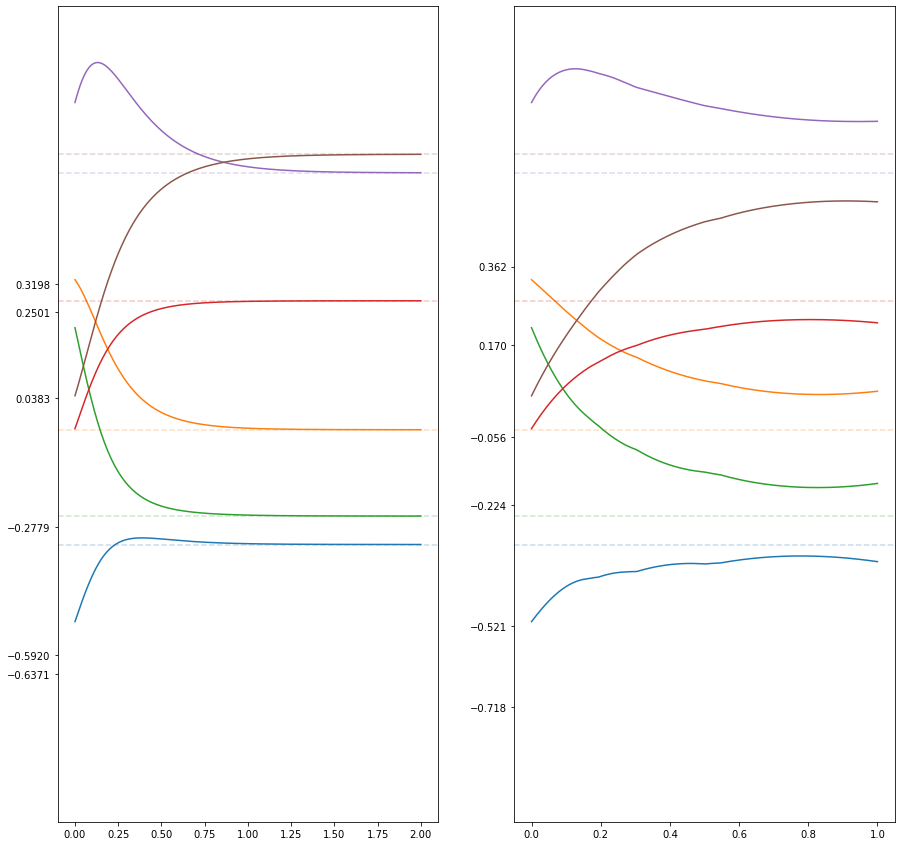

In [21]:
N_output = model(t) 
eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

v_pred_np = np.zeros([t.size(0), 6])
for i in range(t.size(0)):
    ft = f_trial(t[i,:], N_output[i,:].reshape(-1,1)).detach().numpy().reshape(6)
    v_pred_np[i] = ft / np.sqrt(np.dot(ft, ft))

x_t = v0.detach().numpy()
A_t = A.detach().numpy()
dt = 0.01
N = 200

time = np.linspace(0, dt * N, N)

#print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
#print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

x_euler = np.zeros([N, 6])


for i in range(N):
    x_euler[i, :] = x_t.reshape(6)
    x_euler[i, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    x_t = x_t + (-x_t + (x_t.T @ x_t * A_t + (1 - x_t.T @ A_t @ x_t) * np.identity(6)) @ x_t)*dt
x_euler[N-1, :] = x_t.reshape(6)
x_euler[N-1, :] /= np.sqrt(np.dot(x_euler[i, :], x_euler[i, :]))
    

    
#print(x_t/np.sqrt(x_t.T @ x_t)) # normalized eigenvector
#print(x_t.T @ A_t @ x_t / (x_t.T @ x_t)) # eigenvalue

#print(eigvec[:,-1])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.figure(figsize=(15, 15))
plt.subplot(121)
for d in range(6):
    plt.plot(time, -x_euler[:, d], color=colors[d])
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(x_euler[-1, :])
plt.ylim(-1,1)

plt.subplot(122)
for d in range(6):
    plt.plot(t.detach().numpy(), -v_pred_np[:, d], color=colors[d])
    plt.axhline(eigvec[d, -1], alpha=0.25, color=colors[d], ls="--")
plt.yticks(v_pred_np[-1, :])
plt.ylim(-1,1)

plt.show()

In [ ]:
x_t = -v_pred_np[-1, :]
print(x_t.T @ A_t @ x_t / (x_t.T @ x_t))
eigval[-1]

In [ ]:
v_pred = f_trial(t[-1,:], N_output[-1,:].reshape(-1,1))

print("before norm: \n",v_pred)
v_pred = v_pred/v_pred.norm()
print("after norm: \n", v_pred)

eigval, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigval)
print(eigvec)

print(eigvec[:,-1])